<a href="https://colab.research.google.com/github/LeonardoViotti/cdr-training/blob/develop/notebooks/aggregated_cdr_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CDR Analysis

 - Aggregated data
 - Quality Checks
 - Analysis
 - Map

# Environment set-up
Run the cell below:

In [1]:
#------------------------------------------------------------------------
# Libraries installation

# !pip install geopandas

#------------------------------------------------------------------------
# Useful functions

def time_complete(data, timefreq = 'D'):
    data = data.reset_index()
    timevar = data.columns[0]
    data[timevar] = data[timevar].astype('datetime64[D]')
    full_time_range = pd.date_range(data[timevar].min(),  
                                            data[timevar].max(), 
                                            freq = timefreq)
    data = data.set_index(timevar)
    data = data.reindex(full_time_range,  fill_value=0)
    return(data)


# Let's start

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd

First, let's import the datasets we will use on this exercise

In [3]:
# from google.colab import files
# files.upload()

In [4]:
!ls

aggregated-cdr-analysis.ipynb
cdr-processing-with-pyspark-colab.ipynb
test.py
transactions_per_day.csv


## Exercise 1

In [7]:
# Load transactions per day data
tdf = pd.read_csv('transactions_per_day.csv')
tdf.head()

,region,date,value
0,fid000,2020-02-01,54708.362279
1,fid000,2020-02-02,44711.719949
2,fid000,2020-02-05,42863.756194
3,fid000,2020-02-06,40888.184209
4,fid000,2020-02-07,42763.293662


In [9]:
# Aggregate data by day
tdf_day = tdf.groupby('date').agg({'value': np.sum})

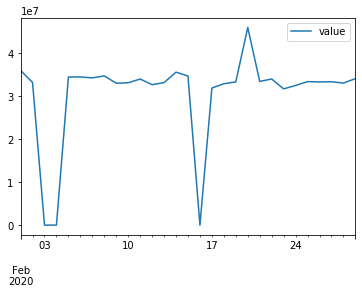

In [14]:
# PLot
tdf_day = time_complete(tdf_day)
tdf_day.plot()

## Exercise 2


## Exercise 3